<a href="https://colab.research.google.com/github/gugi200/final_project/blob/main/project_y4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb -qU
!wandb login 3014974e724f01c4d63f956fa13fd7f0463e16d4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.3 MB/s eta 0:00:00
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
!pip install torchmetrics
!pip install mlxtend>=0.19.0

!pip list | grep mlx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.1 MB/s eta 0:00:00
mlxtend                          0.22.0


In [3]:
#
#   Michael Gugala
#   02/12/2023
#   Image recognition
#   Master 4th year project
#   Univeristy of Bristol
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision
from torchvision import datasets#
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchmetrics
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import Bunch

from PIL import Image

import requests
import random
import shutil
import zipfile
from pathlib import Path
from io import BytesIO, StringIO
import os

import wandb
import cv2
from timeit import default_timer as timer
from tqdm.auto import tqdm

# check imports
print(torch.__version__)
print(torchvision.__version__)

#agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.1.0+cu121
0.16.0+cu121


'cpu'

# Download test data

In [ ]:
# downloiad test data
from torchvision.datasets import FashionMNIST
from torchvision import transforms

train_data = FashionMNIST(
    root='~/.pytorch/F_MNIST_data',
    download=True,
    train=True,
    target_transform=None)

test_data = FashionMNIST(
    root='~/.pytorch/F_MNIST_data',
    download=True,
    train=False,
    target_transform=None)

class_names = [x.replace('/', '_').replace('-', '') for x in train_data.classes]

transform = transforms.ToPILImage()

# download costom data

In [4]:
colabPath = Path("custom_dataset")

#  Create a dir
if colabPath.is_dir():
    print('directory already exists')
else:
    colabPath.mkdir(parents=True, exist_ok=True)

# download zipped data
with open(colabPath / "dataset_pressure_sensor.zip", "wb") as f:
    request = requests.get("https://github.com/gugi200/final_project/raw/main/dataset_pressure_sensor.zip")
    f.write(request.content)


# unzip the data
with zipfile.ZipFile(colabPath / "dataset_pressure_sensor.zip", "r") as f:
    f.extractall(colabPath)



## process the data - rotation, transpose & rotation - VISUALISATION

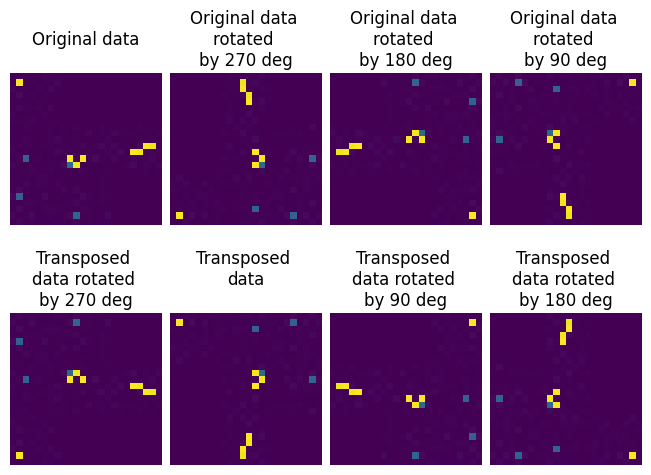

In [5]:
customDirPath = Path("custom_dataset/dataCollection1_sensor")
dirs = os.listdir(customDirPath)
files = os.listdir(customDirPath / dirs[0])


img = Image.open(customDirPath / dirs[0] / files[0])
imgNp1 = np.asarray(img)
imgNp1_T = np.transpose(imgNp1)

imgNp2 = np.rot90(imgNp1)
imgNp3 = np.rot90(imgNp2)
imgNp4 = np.rot90(imgNp3)


imgNp2_T = np.rot90(imgNp1_T)
imgNp3_T = np.rot90(imgNp2_T)
imgNp4_T = np.rot90(imgNp3_T)

fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, constrained_layout = True)

ax1.imshow(imgNp1)
ax2.imshow(imgNp2)
ax3.imshow(imgNp3)
ax4.imshow(imgNp4)
ax6.imshow(imgNp1_T)
ax5.imshow(imgNp2_T)
ax8.imshow(imgNp3_T)
ax7.imshow(imgNp4_T)
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax6.axis('off')
ax5.axis('off')
ax8.axis('off')
ax7.axis('off')
ax1.set_title("Original data\n")
ax2.set_title("Original data \nrotated \nby 270 deg")
ax3.set_title("Original data \nrotated \nby 180 deg")
ax4.set_title("Original data \nrotated \nby 90 deg")
ax6.set_title("Transposed \ndata\n")
ax5.set_title("Transposed \ndata rotated \nby 270 deg")
ax8.set_title("Transposed \ndata rotated \nby 180 deg")
ax7.set_title("Transposed \ndata rotated \nby 90 deg")

plt.show()

In [ ]:
dirs

# Data multiplication

In [5]:

customDirPath = Path("custom_dataset/dataCollection1_sensor")
dirs = os.listdir(customDirPath)


#  Create a dir with processed data
extendedDataPath = Path("extended_custom_dataset")
if extendedDataPath.is_dir():
    print('directory already exists')
else:
    extendedDataPath.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = extendedDataPath / dir
        path.mkdir(parents=True, exist_ok=True)



index = 0
for dir in dirs:
    files = os.listdir(customDirPath / dir)

    for file in files:
        img = Image.open(customDirPath / dir / file)
        imgNp = np.asarray(img)
        imgNp_T = np.transpose(imgNp)

        im = Image.fromarray(imgNp)
        im.save(f"{extendedDataPath}/{dir}/{dir}_{index}.jpg")

        im = Image.fromarray(imgNp_T)
        im.save(f"{extendedDataPath}/{dir}/{dir}_{index+1}.jpg")
        for i in range(3):
            imgNp = np.rot90(imgNp)
            imgNp_T = np.rot90(imgNp_T)

            im = Image.fromarray(imgNp)
            im.save(f"{extendedDataPath}/{dir}/{dir}_{(index) + (2*(i+1))}.jpg")

            im = Image.fromarray(imgNp_T)
            im.save(f"{extendedDataPath}/{dir}/{dir}_{(index) + (2*(i+1)) + 1}.jpg")

        index += 8
l = 0
for dir in dirs:
    l += len(os.listdir(extendedDataPath/dir))
    print(dir, len(os.listdir(extendedDataPath/dir)), len(os.listdir(customDirPath/dir)), len(os.listdir(customDirPath/dir))*8)
print(l)

mug 8520 1065 8520
h_bottle 8136 1017 8136
h_big_bottle 7824 978 7824
small_fizzy 8320 1040 8320
hand 8032 1004 8032
big_fizzy 8032 1004 8032
48864


## split the data into traina and test

In [6]:
TRAIN_RATIO = 0.75
dirs = os.listdir(extendedDataPath)


#  Create a dir for train and test data
extendedTrain = Path("extended_train")
extendedTest = Path("extended_test")
if extendedTrain.is_dir():
    print('directory already exists')
else:
    extendedTrain.mkdir(parents=True, exist_ok=True)
    extendedTest.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = extendedTrain / dir
        path.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = extendedTest / dir
        path.mkdir(parents=True, exist_ok=True)

for dir in dirs:
    files = os.listdir(extendedDataPath / dir)
    length = int(TRAIN_RATIO*len(files))
    random.shuffle(files)

    train_set = files[:length]
    test_set = files[length:]

    for data in train_set:
        shutil.copy(extendedDataPath / dir / data, extendedTrain / dir / data)

    for data in test_set:
        shutil.copy(extendedDataPath / dir / data, extendedTest / dir / data)

l = 0
for dir in dirs:
    l += len(os.listdir(extendedTrain/dir))
    print(dir, len(os.listdir(extendedTrain/dir)))
print(l)

l = 0
for dir in dirs:
    l += len(os.listdir(extendedTest/dir))
    print(dir, len(os.listdir(extendedTest/dir)))
print(l)


mug 6390
h_bottle 6102
h_big_bottle 5868
small_fizzy 6240
hand 6024
big_fizzy 6024
36648
mug 2130
h_bottle 2034
h_big_bottle 1956
small_fizzy 2080
hand 2008
big_fizzy 2008
12216


# Create a small data subset for testing


In [ ]:
!rm -R short_test short_train

rm: cannot remove 'short_test': No such file or directory
rm: cannot remove 'short_train': No such file or directory


In [8]:

TRAIN_LENGTH_PER_CLASS = 100
TEST_LENGTH_PER_CLASS = 25
dirs = os.listdir(extendedDataPath)


#  Create a dir for train and test data
shortTrain = Path("short_train")
shortTest = Path("short_test")
if shortTrain.is_dir():
    print('directory already exists')
else:
    shortTrain.mkdir(parents=True, exist_ok=True)
    shortTest.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = shortTrain / dir
        path.mkdir(parents=True, exist_ok=True)
    for dir in dirs:
        path = shortTest / dir
        path.mkdir(parents=True, exist_ok=True)

for dir in dirs:
    files = os.listdir(extendedDataPath / dir)
    random.shuffle(files)

    train_set = files[:TRAIN_LENGTH_PER_CLASS]
    test_set = files[TRAIN_LENGTH_PER_CLASS:TRAIN_LENGTH_PER_CLASS+TEST_LENGTH_PER_CLASS]

    for data in train_set:
        shutil.copy(extendedDataPath / dir / data, shortTrain / dir / data)

    for data in test_set:
        shutil.copy(extendedDataPath / dir / data, shortTest / dir / data)

l = 0
for dir in dirs:
    l += len(os.listdir(shortTrain/dir))
    print(dir, len(os.listdir(shortTrain/dir)))
print(l)

l = 0
for dir in dirs:
    l += len(os.listdir(shortTest/dir))
    print(dir, len(os.listdir(shortTest/dir)))
print(l)


big_fizzy 100
mug 100
h_bottle 100
small_fizzy 100
h_big_bottle 100
hand 100
600
big_fizzy 25
mug 25
h_bottle 25
small_fizzy 25
h_big_bottle 25
hand 25
150


# split test dataset into dirs by class

In [14]:

from pathlib import Path

data_path = Path("data/")
image_path1 = data_path / "FashionMNIST" / "train"

if image_path1.is_dir():
    print('directory already exists')
else:
    print('creating folder')
    for class_name in class_names:
        image_class_path = image_path1 / class_name
        image_class_path.mkdir(parents=True, exist_ok=True)

    for idx, (train_img, target) in enumerate(zip(train_data.data[:1000], train_data.targets[:1000])):
        train_data_PIL = transform(train_img)
        file = "data_" + str(idx) + '.jpg'
        train_data_PIL.save(data_path / "FashionMNIST"/"train" / class_names[target] /file)


data_path = Path("data/")
image_path2 = data_path / "FashionMNIST" / "test"
if image_path2.is_dir():
    print('directory already exists')
else:
    print('creating folder')
    for class_name in class_names:
        image_class_path = image_path2 / class_name
        image_class_path.mkdir(parents=True, exist_ok=True)
        image_class_path.mkdir(parents=True, exist_ok=True)

    for idx, (test_img, target) in enumerate(zip(test_data.data[:250], test_data.targets[:250])):
        test_data_PIL = transform(test_img)
        file = "data_" + str(idx) + '.jpg'
        test_data_PIL.save(data_path / "FashionMNIST"/"test" / class_names[target] /file)





creating folder


AttributeError: 'ImageFolder' object has no attribute 'data'

# Plan of action
A.
1. Create different CNN models
    * a few of my own making
    * restnet
    * maybe something else
2. Train them on MNIST fashion data scaled to 24x24
3. a Loop to find the best hyperparameters

B. Create SVM models in scikit learn
1. Create a pipeline with different hyper parameters


# Prepare data
* trasnform to tensors
* upscale to 224 (restnet size)
* normalize (apply different normalization)

In [10]:
preprocess = transforms.Compose([

    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.25, 0.25, 0.25], std=[0.1, 0.1, 0.1]),
])
# path = colabPath / "dataCollection1_sensor"
# path_train = "data/FashionMNIST/train"
# path_test = "data/FashionMNIST/test"
path_train = "extended_train"
path_test = "extended_test"
train_data = datasets.ImageFolder(root=path_train,
                                 transform=preprocess, # tranform for the data
                                  target_transform=None) # transform for label


test_data = datasets.ImageFolder(root=path_test,
                                 transform=preprocess, # tranform for the data
                                  target_transform=None) # transform for label
class_names = train_data.classes

# Visualise

In [ ]:
# split data into batches
from torch.utils.data import DataLoader
BATCH_SIZE = 32

# turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) #  shuffling to remove order

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False) # here it doesn't matter, no point to waste resources


# iter tranforms it into iterable, next accesses the next batch
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)

# display random datapoints
fig = plt.figure(figsize=(9, 9))
rows, cols  = 3, 3
for pic in range(1, 1+rows*cols):
    rand_int = np.random.randint(0, BATCH_SIZE)
    img = train_features_batch[rand_int]
    img_RGB = img.permute([1, 2, 0]).numpy()
    fig.add_subplot(rows, cols, pic)
    plt.imshow(img_RGB.squeeze())
    plt.axis(False)
    plt.title(class_names[train_labels_batch[rand_int]])





# Create models



### Create training loop

create dataset

In [7]:
from pickle import NONE
# create data set from a custom data
def create_dataset(path, batchsize, mean=None, std=None):
    '''
    input:
    path - path to the folder with the data
           eg for train - "data/FashionMNIST/train"
    batchsize - eg 32
    mean (optional)- for normalization eg. [0.25, 0.25, 0.25]
    std (optional)- for nortmalization eg [0.1, 0.1, 0.1]

    returns:
    dataloader with image size of 224
    class_names
    '''
    if mean:
        preprocess = transforms.Compose([

            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    else:
        preprocess = transforms.Compose([

            transforms.Resize(size=(224, 224)),
            transforms.ToTensor()
        ])


    data = datasets.ImageFolder(root=Path(path),
                                    transform=preprocess, # tranform for the data
                                    target_transform=None) # transform for label
    dataloader = DataLoader(dataset=data,
                                batch_size=batchsize,
                                shuffle=True) #  shuffling to remove order
    class_names = data.classes
    return dataloader, class_names, data.targets

# visdualize 9 random images in a batch
def visualise_data(dataloader, class_names, batchsize):
    '''
    input dataloader
    class names

    displays 9 random images in a batch and their labels
    '''
    train_features_batch, train_labels_batch = next(iter(dataloader))
    print("length of data: ", len(train_features_batch), 'length of labels: ', len(train_labels_batch))
    # display random datapoints
    fig = plt.figure(figsize=(9, 9))
    rows, cols  = 3, 3
    for pic in range(1, 1+rows*cols):
        rand_int = np.random.randint(0, batchsize)
        img = train_features_batch[rand_int]
        img_RGB = img.permute([1, 2, 0]).numpy()
        fig.add_subplot(rows, cols, pic)
        plt.imshow(img_RGB.squeeze())
        plt.axis(False)
        plt.title(class_names[train_labels_batch[rand_int]])


# create optimizer
def create_optiimizer(model, optimizer, lr):
    '''
    inputs:
    model - CNN network
    optimizer - "adam" or "sgd"
    lr - learning rate eg. 0.01

    '''
    if optimizer=='adam':
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=lr
                                     )
    elif optimizer=='sgd':
        optimizer = torch.optim.SGD(model.parameters(),
                                     lr=lr,
                                    momentum=0.9
                                     )

    return optimizer


def get_lossFn():
    '''
        returns CrossEntropyLoss function
    '''

    return nn.CrossEntropyLoss()

# create train step
def train_step(model, metric, loss_fn, optimizer,
               data_loader, device, debug=False, wnb=True):
    '''
    model - CNN network
    metric - metric to calculate accuracy
    loss_fn - loss function
    optimizer - optimizer to be applied
    data_loader - dataloader
    device - decide for the model to train
    debug (optional)- if True prints average loss and metric of the batch

    returns
    train_loss - average loss of the batch
    train_acc - average metric score of the batch

    The function saves the metric score and loss of each iteration in WandB

    '''
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # put data on the device
        X, y = X.to(device), y.to(device)

        #forward pass, return raw logits
        y_pred = model(X)

        #loss
        loss = loss_fn(y_pred, y)
        #accuracy
        acc = metric(y, torch.argmax(y_pred, dim=1))

        train_loss += loss # accumulate train loss
        train_acc += acc # accumulate train accuracy

        # zero grad
        optimizer.zero_grad()

        # loss bacward
        loss.backward()

        #optimizer step
        optimizer.step()

        # log in wandb
        if wnb:
            wandb.log({"loss": loss,
                       'accuracy': acc})

    # device total loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if debug:
        print(f'Train loss: {train_loss:.4f}, Train acc: {train_acc*100:0.4f}%')

    return train_loss, train_acc


# create test step
def test_step(model, metric, loss_fn, data_loader, device, debug=False, wnb=True):
    '''
    model - CNN network
    metric - metric to calculate accuracy
    loss_fn - loss function
    data_loader - dataloader
    device - decide for the model to train
    debug (optional)- if True prints average loss and metric of the batch

    returns
    test_loss - average loss of the batch
    test_acc - average metric score of the batch

    The function saves the metric score and loss of each iteration in WandB

    '''
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            #1 forward pass
            test_pred = model(X_test)

            # calculate loss
            loss = loss_fn(test_pred, y_test)
            test_loss += loss

            #accuracy
            acc = metric(y_test, test_pred.argmax(dim=1))
            test_acc += acc

            if wnb:
                wandb.log({"test loss": loss,
                           'test accuracy': acc})

        # Calculate the test loss average batch
        test_loss /= len(data_loader)

        # acc per bactch
        test_acc /= len(data_loader)

        # Print out what's happening
        if debug:
            print(f'Test loss: {test_loss:.4f}  |  Test acc: {test_acc*100:.4f}%')

        return test_loss, test_acc

# create evaluation loop
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
               device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            #accumulate the loss and acc
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # ave loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works if a model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()*100}




def visualize_preds(model, dataloader, class_names, batchsize):
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3
    model = model.cpu()

    dataL_len = len(dataloader)
    data = iter(dataloader)
    for i in range(3):
        model.eval()
        with torch.inference_mode():

            X, y = next(data)
            X, y = X.cpu(), y.cpu()
            for j in range(3):
                randint = np.random.randint(0, batchsize)
                X_sample, y_sample = X[randint], y[randint]
                pred_logit = model(X_sample.unsqueeze(dim=0))

                pred_prob = pred_logit.argmax(dim=1)


                plt.subplot(nrows, ncols, (3*i)+j+1);
                plt.imshow(X_sample.squeeze().permute([1, 2, 0]), cmap='gray');

                #find pred_label in text form
                pred_label = class_names[pred_prob];

                # find truth label
                truth_label = class_names[y_sample];

                title_text = f'Pred: {pred_label}  \n  Truth: {truth_label}'

                if pred_label==truth_label:
                    plt.title(title_text, fontsize=10, c='g');
                else:
                    plt.title(title_text, fontsize=10, c='r');
                plt.axis(False)
                plt.tight_layout()



def plot_decision_matrix(class_names, y_pred_tensor, targets):
    # setup confusion matrix
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

    confmat_tensor = confmat(preds=y_pred_tensor,
                            target=targets)

    # plot consufionmatrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10, 7)
    )

def make_predictions(model, data, device):
    model.eval()
    data = data.to(device)
    model = model.to(device)
    with torch.inference_mode():
        y_preds = model(data)
    return y_preds.cpu()

def make_predictions_dataloader(model, dataloader, device):
    preds = []
    target = []
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            batch_pred = model(X_test)
            batch_pred = batch_pred.cpu()
            y_test = y_test.cpu()
            preds.append(np.array(batch_pred.argmax(dim=1)))
            target.append(y_test)
    pred = np.array(preds)
    target = np.array(target)
    return np.concatenate(pred), np.concatenate(target)




def dataloader_to_numpy(dataloader):
    for i, (data, target) in enumerate(dataloader):
        if i==0:
            data_numpy = data.numpy()
            target_numpy = target.numpy()
        else:
            data_numpy = np.append(data_numpy, data.numpy(), axis=0)
            target_numpy = np.append(target_numpy, target.numpy(), axis=0)
    return data_numpy, target_numpy


def get_datalodaer(train_data_path, test_data_path, batchsize):

    train_dataloader, class_names, _ = create_dataset(
                                        path=train_data_path,
                                        batchsize=batchsize,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                    )
    test_dataloader, _, _ = create_dataset(
                                path=test_data_path,
                                batchsize=batchsize,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                    )
    return train_dataloader, test_dataloader, class_names


def train_test_loop(config, model, train_dataloader, test_dataloader,
                    class_names):
    loss_fn = get_lossFn()
    optimizer = create_optiimizer(model=model,
                                    optimizer=config.optimizer,
                                    lr=config.learning_rate
    )
    metric = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=len(class_names)
    ).to(device)
    train_time_start = timer()
    for epoch in range(config.epochs):
        ave_batch_loss, ave_batch_metric = train_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            debug=True
        )
        ve_batch_loss, ave_batch_metric = test_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            device=device,
            debug=True
        )
        wandb.log({"average train batch loss": ave_batch_loss,
                    "average train batch metric": ave_batch_metric,
                    "average test batch loss": ave_batch_loss,
                    "average test batch metric": ave_batch_metric,
                    "epoch": epoch
                    })
    train_time_end = timer()
    wandb.log({"train time": train_time_end - train_time_start})



## First test loop
test on FashionMNIST with a loop of different hyper parammeters and wandb experiment result collection

In [ ]:

train_dataloader, class_names, targets = create_dataset(
                                     path=path_train,
                                     batchsize=BATCH_SIZE
                                     )
test_dataloader, _, _ = create_dataset(
                             path=path_test,
                             batchsize=BATCH_SIZE
                             )

visualise_data(dataloader=train_dataloader, class_names=class_names, batchsize=BATCH_SIZE)

In [ ]:
class_names, len(targets), np.unique(np.array(targets)), max(targets)

# Run the testing resnet model with test data

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]


cuda


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.2274, Train acc: 57.4405%
Test loss: 0.8151  |  Test acc: 67.5000%
Train loss: 0.6254, Train acc: 77.6786%
Test loss: 1.4661  |  Test acc: 65.4688%
Train loss: 0.5123, Train acc: 81.2500%
Test loss: 0.6663  |  Test acc: 75.1562%
Train loss: 0.3752, Train acc: 87.1032%
Test loss: 0.5385  |  Test acc: 81.4844%
Train loss: 0.3304, Train acc: 88.2937%
Test loss: 0.5085  |  Test acc: 81.2500%


<ipython-input-10-b39045ed7062>:250: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrows, ncols, (3*i)+j+1);


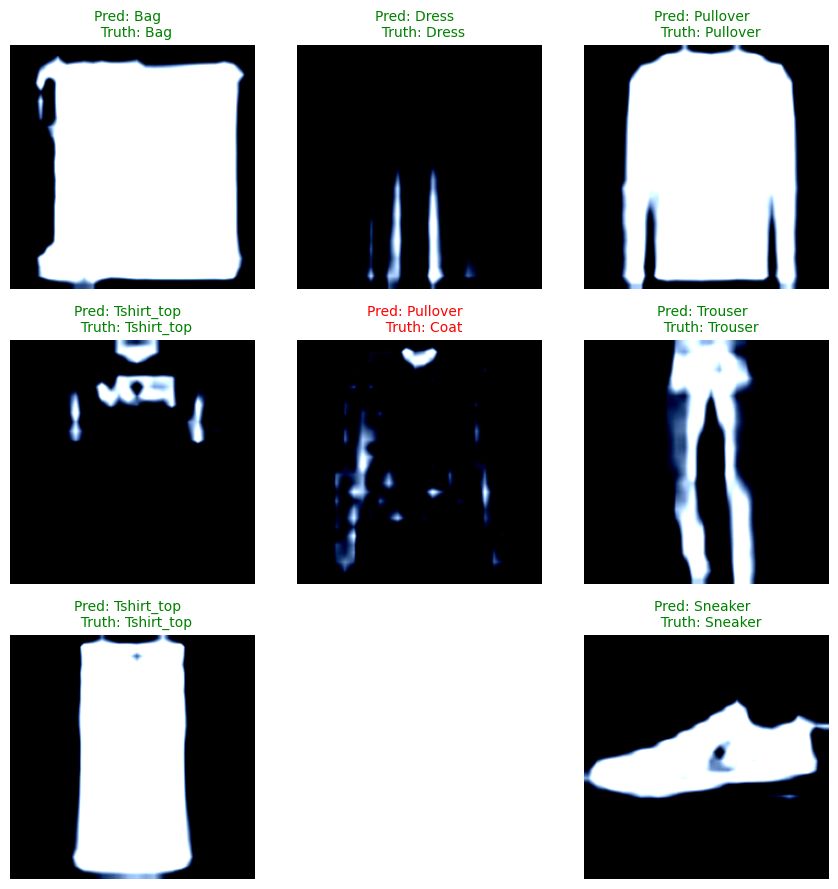

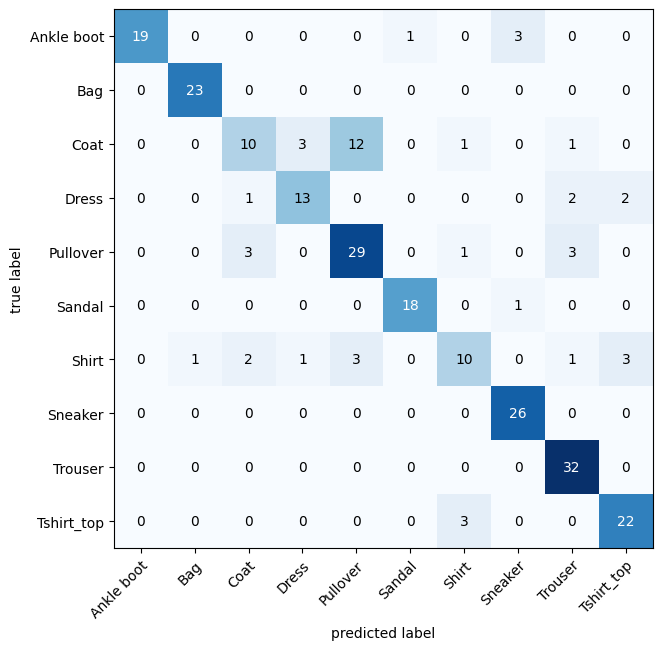

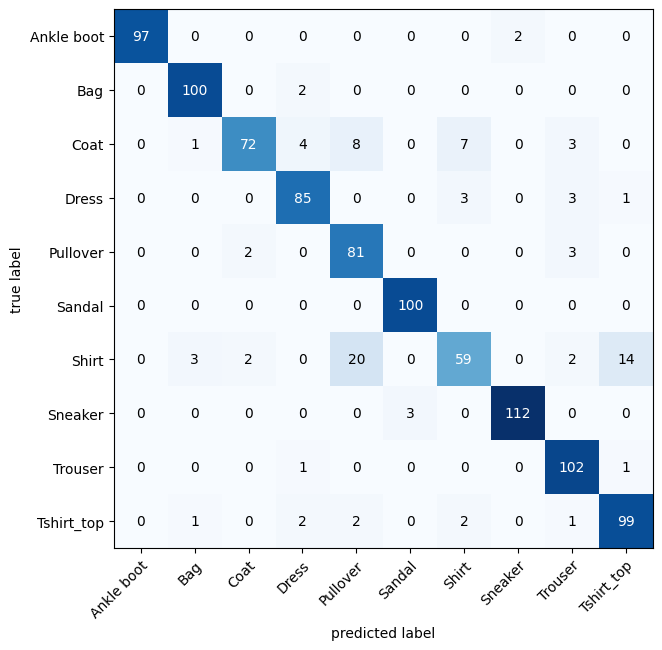

In [ ]:
# test with no hyperparameter sweeping
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from torchvision.models import resnet50, ResNet50_Weights
BATCH_SIZE = 16
# get data
train_dataloader, class_names, targets = create_dataset(
                                    path="data/FashionMNIST/train",
                                    batchsize=BATCH_SIZE,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )
test_dataloader, _, _ = create_dataset(
                            path="data/FashionMNIST/test",
                            batchsize=BATCH_SIZE,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )

# get model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(2048, len(class_names))


def train_model_restent50(train_dataloader, test_dataloader, lr, optimizer, batchsize, epochs, class_names, model):
    print(device)

    model = model.to(device)
    loss_fn = get_lossFn()
    optimizer = create_optiimizer(model=model,
                                    optimizer=optimizer,
                                    lr=lr
    )


    metric = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=len(class_names)
    ).to(device)
    train_time_start = timer()
    for epoch in tqdm(range(epochs)):
        ave_batch_loss, ave_batch_metric = train_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            wnb=False,
            debug=True
        )
        ve_batch_loss, ave_batch_metric = test_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            device=device,
            wnb=False,
            debug=True
        )

    train_time_end = timer()

    return model

newModel = train_model_restent50(train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 lr=0.001,
                                 optimizer='adam',
                                 batchsize=BATCH_SIZE,
                                 epochs=5,
                                 class_names=class_names,
                                 model=model).cpu()

visualize_preds(model=newModel,
                dataloader=test_dataloader,
                class_names=class_names,
                batchsize=BATCH_SIZE)

data_test_numpy, target_test_numpy = dataloader_to_numpy(test_dataloader)

y_test_preds_tensor = make_predictions(model=newModel,
                           data=torch.tensor(data_test_numpy),
                           device=device
                        )

plot_decision_matrix(class_names=class_names,
                     y_pred_tensor=y_test_preds_tensor,
                     targets=torch.tensor(target_test_numpy))


data_train_numpy, target_train_numpy = dataloader_to_numpy(train_dataloader)

y_train_preds_tensor = make_predictions(model=newModel,
                           data=torch.tensor(data_train_numpy),
                           device=device
                        )

plot_decision_matrix(class_names=class_names,
                     y_pred_tensor=y_train_preds_tensor,
                     targets=torch.tensor(target_train_numpy))



# tests

# Run the test model with subset of custom data

In [ ]:
# test with no hyperparameter sweeping
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from torchvision.models import resnet50, ResNet50_Weights
BATCH_SIZE = 16
# get data
train_dataloader, class_names, targets = create_dataset(
                                    path=extendedTrain,
                                    batchsize=BATCH_SIZE,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )
test_dataloader, _, _ = create_dataset(
                            path=extendedTest,
                            batchsize=BATCH_SIZE,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )

# get model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(2048, len(class_names))


def train_model_restent50(train_dataloader, test_dataloader, lr, optimizer, batchsize, epochs, class_names, model):
    print(device)

    model = model.to(device)
    loss_fn = get_lossFn()
    optimizer = create_optiimizer(model=model,
                                    optimizer=optimizer,
                                    lr=lr
    )


    metric = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=len(class_names)
    ).to(device)
    train_time_start = timer()
    for epoch in tqdm(range(epochs)):
        ave_batch_loss, ave_batch_metric = train_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            wnb=False,
            debug=True
        )
        ve_batch_loss, ave_batch_metric = test_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            device=device,
            wnb=False,
            debug=True
        )

    train_time_end = timer()

    return model

newModel = train_model_restent50(train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 lr=0.001,
                                 optimizer='adam',
                                 batchsize=BATCH_SIZE,
                                 epochs=5,
                                 class_names=class_names,
                                 model=model).cpu()

visualize_preds(model=newModel,
                dataloader=test_dataloader,
                class_names=class_names,
                batchsize=BATCH_SIZE)


preds, targets = make_predictions_dataloader(newModel, train_dataloader, device)

plot_decision_matrix(class_names=class_names,
                     y_pred_tensor=torch.tensor(preds),
                     targets=torch.tensor(targets))


preds, targets = make_predictions_dataloader(newModel, test_dataloader, device)

plot_decision_matrix(class_names=class_names,
                     y_pred_tensor=torch.tensor(preds),
                     targets=torch.tensor(targets))




Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.4MB/s]


cpu


  0%|          | 0/5 [00:00<?, ?it/s]

# The main loop

set up for the pipelines

In [13]:





torch.manual_seed(42)
torch.cuda.manual_seed(42)


sweep_config = {
    'method': 'grid'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [6]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 5}
    })

# parameters_dict.update({
#     'learning_rate': {
#         # a flat distribution between 0 and 0.1
#         'distribution': 'uniform',
#         'min': 0,
#         'max': 0.1
#       },
#     'batch_size': {
#         # integers between 32 and 256
#         # with evenly-distributed logarithms
#         'distribution': 'q_log_uniform_values',
#         'q': 8,
#         'min': 8,
#         'max': 32,
#       }
#     })

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'values': [0.001, 0.01, 0.1]
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'values': [16, 32]
      }
    })



import pprint
pprint.pprint(sweep_config)


def train_model_resnet50(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        model = resnet50(
            weights=ResNet50_Weights.DEFAULT).to(device)
        model.fc = nn.Linear(2048 , config.fc_layer_size).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_alexnet(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('alexnet'))[-1]
        model = torch.hub.load('pytorch/vision', 'alexnet', weight).to(device)
        model.classifier[6] = nn.Linear(4096 , 10).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_convnext_base(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('convnext_base'))[-1]
        model = torch.hub.load('pytorch/vision', 'convnext_base', weight).to(device)
        model.classifier[2] = nn.Linear(1024 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_densenet161(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('densenet161'))[-1]
        model = torch.hub.load('pytorch/vision', 'densenet161', weight).to(device)
        model.classifier = nn.Linear(2208 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_efficientnet_v2_l(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('efficientnet_v2_l'))[-1]
        model = torch.hub.load('pytorch/vision', 'efficientnet_v2_l', weight).to(device)
        model.classifier[1] = nn.Linear(1280 , 10, bias=True).to(device).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_googlenet(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('googlenet'))[-1]
        model = torch.hub.load('pytorch/vision', 'googlenet', weight).to(device)
        model.fc = nn.Linear(1024 , 10, bias=True).to(device)
        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_inception_v3(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('inception_v3'))[-1]
        model = torch.hub.load('pytorch/vision', 'inception_v3', weight).to(device)
        model.fc = nn.Linear(2048 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_maxvit_t(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('maxvit_t'))[-1]
        model = torch.hub.load('pytorch/vision', 'maxvit_t', weight).to(device)
        model.classifier[5] = nn.Linear(512 , 10, bias=False).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_mobilenet_v3_large(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('mobilenet_v3_large'))[-1]
        model = torch.hub.load('pytorch/vision', 'mobilenet_v3_large', weight).to(device)
        model.classifier[3] = nn.Linear(1280 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model


def train_model_shufflenet_v2_x2_0(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('shufflenet_v2_x2_0'))[-1]
        model = torch.hub.load('pytorch/vision', 'shufflenet_v2_x2_0', weight).to(device)
        model.fc = nn.Linear(2048 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_swin_v2_t(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('swin_v2_t'))[-1]
        model = torch.hub.load('pytorch/vision', 'swin_v2_t', weight).to(device)
        model.head = nn.Linear(768 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_vgg19_bn(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('vgg19_bn'))[-1]
        model = torch.hub.load('pytorch/vision', 'vgg19_bn', weight).to(device)
        model.classifier[6] = nn.Linear(4096 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_wide_resnet50_2(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            train_data_path = shortTrain,
            test_data_path = shortTest,
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('wide_resnet50_2'))[-1]
        model = torch.hub.load('pytorch/vision', 'wide_resnet50_2', weight).to(device)
        model.fc = nn.Linear(2048 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model


count=10


{'method': 'grid',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [16, 32]},
                'epochs': {'value': 5},
                'fc_layer_size': {'values': [6]},
                'learning_rate': {'values': [0.001, 0.01, 0.1]},
                'optimizer': {'values': ['adam', 'sgd']}}}


# Run individual pipelines seperatelly to avoid system crashing

In [ ]:
# restnet pipeline
sweep_id_restnet50 = wandb.sweep(sweep_config, project="restnet-test")
wandb.agent(sweep_id_restnet50, train_model_resnet50, count=count)

In [ ]:
# alexnet pipeline
sweep_id_alexnet = wandb.sweep(sweep_config, project="alexnet-test")
wandb.agent(sweep_id_alexnet, train_model_alexnet, count=count)

In [ ]:
# convnext_base pipeline
sweep_id_convnext_base = wandb.sweep(sweep_config, project="convnext_base-test")
wandb.agent(sweep_id_convnext_base, train_model_convnext_base, count=count)

In [ ]:
# densenet161 pipeline
sweep_id_densenet161 = wandb.sweep(sweep_config, project="densenet161-test")
wandb.agent(sweep_id_densenet161, train_model_densenet161, count=count)

In [14]:
# efficientnet_v2_l pipeline
sweep_id_efficientnet_v2_l = wandb.sweep(sweep_config, project="efficientnet_v2_l-test")
wandb.agent(sweep_id_efficientnet_v2_l, train_model_efficientnet_v2_l, count=count)

Create sweep with ID: ou1xtqal
Sweep URL: https://wandb.ai/gugi200/efficientnet_v2_l-test/sweeps/ou1xtqal


wandb: Agent Starting Run: kzpcipne with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 6
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: ad20781 (gugi200). Use `wandb login --relogin` to force relogin


Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:03<00:00, 121MB/s]


Train loss: 1.2728, Train acc: 56.7434%
Test loss: 1.9605  |  Test acc: 40.0000%
Train loss: 0.7757, Train acc: 73.8487%
Test loss: 0.6253  |  Test acc: 74.7917%
Train loss: 0.6502, Train acc: 78.4539%
Test loss: 0.6499  |  Test acc: 79.5833%
Train loss: 0.5423, Train acc: 85.3618%
Test loss: 0.6344  |  Test acc: 78.7500%


Traceback (most recent call last):
  File "<ipython-input-13-38f261dcf365>", line 162, in train_model_efficientnet_v2_l
    train_test_loop(config=config,
  File "<ipython-input-12-9478190983b9>", line 333, in train_test_loop
    ave_batch_loss, ave_batch_metric = train_step(
  File "<ipython-input-12-9478190983b9>", line 124, in train_step
    acc = metric(y, torch.argmax(y_pred, dim=1))
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchmetrics/metric.py", line 303, in forward
    self._forward_cache = self._forward_reduce_state_update(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchmetrics/metric.py", line 372, in _forward_reduce_state_update
    self.update(*args, **

accuracy,▁▃▄▆▃▅▅▅▂▃▇▆▅▆▇▃▅▆▄▆▅▆▆▆▇▇▇▇█▇▇▆▆█▆▆▆▆▆▇
average test batch loss,█▃▂▁
average test batch metric,▁▇██
average train batch loss,█▃▂▁
average train batch metric,▁▇██
epoch,▁▃▆█
loss,█▆▅▄▆▄▃▄▇▄▂▂▆▃▂▄▄▃▅▂▃▄▃▄▂▃▂▂▁▃▃▂▂▁▃▂▃▃▃▁
test accuracy,▂▁▄▃▄▂▃▄▃▄▇▄▅▆▆▆▆▆▆▅▆▆▆▅▇▅▅█▆▇▆▆▅█▇▅▆▆▇▄
test loss,██▅▅▆▇▆▅▇▅▁▄▃▂▂▂▃▂▃▂▃▂▂▃▃▄▃▁▂▂▄▃▂▁▂▂▃▂▂▄
accuracy,0.9375
average test batch loss,0.54227


Run kzpcipne errored: RuntimeError('Detected more unique values in `target` than `num_classes`. Expected only 6 but found 7 in `target`.')
wandb: ERROR Run kzpcipne errored: RuntimeError('Detected more unique values in `target` than `num_classes`. Expected only 6 but found 7 in `target`.')
wandb: Agent Starting Run: gm12qeg1 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	fc_layer_size: 6
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-13-38f261dcf365>", line 162, in train_model_efficientnet_v2_l
    train_test_loop(config=config,
  File "<ipython-input-12-9478190983b9>", line 333, in train_test_loop
    ave_batch_loss, ave_batch_metric = train_step(
  File "<ipython-input-12-9478190983b9>", line 119, in train_step
    y_pred = model(X)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/efficientnet.py", line 343, in forward
    return self._forward_impl(x)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/efficientnet.py", line 333, in _forward_impl
    x = self.features(x

Run gm12qeg1 errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 5.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 68.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run gm12qeg1 errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 5.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.52 GiB is allocated by PyTorch, and 68.13 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: 

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-13-38f261dcf365>", line 159, in train_model_efficientnet_v2_l
    model = torch.hub.load('pytorch/vision', 'efficientnet_v2_l', weight).to(device)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1160, in to
    return self._apply(convert)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  [Previous line repeated 3 more times]
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 833, in _apply
    param_applied = fn(param)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line

Run ef3zuzly errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 54.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run ef3zuzly errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 54.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: p2

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-13-38f261dcf365>", line 159, in train_model_efficientnet_v2_l
    model = torch.hub.load('pytorch/vision', 'efficientnet_v2_l', weight).to(device)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1160, in to
    return self._apply(convert)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  [Previous line repeated 3 more times]
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 833, in _apply
    param_applied = fn(param)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line

Run p2cjfbev errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 54.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run p2cjfbev errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 54.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: sl

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-13-38f261dcf365>", line 159, in train_model_efficientnet_v2_l
    model = torch.hub.load('pytorch/vision', 'efficientnet_v2_l', weight).to(device)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1160, in to
    return self._apply(convert)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  [Previous line repeated 3 more times]
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 833, in _apply
    param_applied = fn(param)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line

Run sl3pdtuw errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 54.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run sl3pdtuw errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 54.38 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: Agent Starting Run: jq

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-13-38f261dcf365>", line 159, in train_model_efficientnet_v2_l
    model = torch.hub.load('pytorch/vision', 'efficientnet_v2_l', weight).to(device)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1160, in to
    return self._apply(convert)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 810, in _apply
    module._apply(fn)
  [Previous line repeated 3 more times]
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 833, in _apply
    param_applied = fn(param)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line

Run jq4uohch errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 54.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
wandb: ERROR Run jq4uohch errored: OutOfMemoryError('CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 1.06 MiB is free. Process 16945 has 14.74 GiB memory in use. Of the allocated memory 14.54 GiB is allocated by PyTorch, and 54.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF')
Detected 5 failed runs in a r

In [ ]:
# googlenet pipeline
sweep_id_googlenet = wandb.sweep(sweep_config, project="googlenet-test")
wandb.agent(sweep_id_googlenet, train_model_googlenet, count=count)

In [ ]:

# inception_v3 pipeline
sweep_id_inception_v3 = wandb.sweep(sweep_config, project="inception_v3-test")
wandb.agent(sweep_id_inception_v3, train_model_inception_v3, count=count)

In [ ]:
# maxvit_t pipeline
sweep_id_maxvit_t = wandb.sweep(sweep_config, project="maxvit_t-test")
wandb.agent(sweep_id_maxvit_t, train_model_maxvit_t, count=count)

In [ ]:
# mobilenet_v3_large pipeline
sweep_id_mobilenet_v3_large = wandb.sweep(sweep_config, project="mobilenet_v3_large-test")
wandb.agent(sweep_id_mobilenet_v3_large, train_model_mobilenet_v3_large, count=count)

In [ ]:
# shufflenet_v2_x2_0 pipeline
sweep_id_shufflenet_v2_x2_0 = wandb.sweep(sweep_config, project="shufflenet_v2_x2_0-test")
wandb.agent(sweep_id_shufflenet_v2_x2_0, train_model_shufflenet_v2_x2_0, count=count)

In [ ]:
# swin_v2_t pipeline
sweep_id_swin_v2_t = wandb.sweep(sweep_config, project="swin_v2_t-test")
wandb.agent(sweep_id_swin_v2_t, train_model_swin_v2_t, count=count)

In [ ]:
# vgg19_bnvgg19_bn pipeline
sweep_id_vgg19_bn = wandb.sweep(sweep_config, project="vgg19_bn-test")
wandb.agent(sweep_id_vgg19_bn, train_model_vgg19_bn, count=count)


In [ ]:
# wide_resnet50_2 pipeline
sweep_id_wide_resnet50_2 = wandb.sweep(sweep_config, project="wide_resnet50_2-test")
wandb.agent(sweep_id_wide_resnet50_2, train_model_wide_resnet50_2, count=count)

# I dont remember what it is

probably testing

In [ ]:
weight = list(torchvision.models.get_model_weights('inception_v3'))[-1]
model = torch.hub.load('pytorch/vision', 'inception_v3', weight).to(device)
model

In [ ]:
weight = list(torchvision.models.get_model_weights('regnet_y_400mf'))[-1]
model = torch.hub.load('pytorch/vision', 'regnet_y_400mf', weight).to(device)
print(model)
model.fc = nn.Linear(440 , 10, bias=True).to(device)

# Testing different CNN models
* RestNet
* AlexNet
* VGGNet
* GoogLeNet/Inception
* DenseNet

In [ ]:
model_list = [
    'alexnet',
    'restnet50',
    'convnext_base',
    'densenet121', 'densenet161', 'densenet169', 'densenet201',
    'efficientnet_b4', 'efficientnet_v2_l',
    'googlenet',
    'inception_v3',
    'maxvit_t',
    'mobilenet_v3_large',
    'regnet_y_400mf',
    'shufflenet_v2_x2_0',
    'swin_v2_t',
    'vgg19', 'vgg19_bn','vgg13',
    'wide_resnet50_2']